In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
import cv2
import joblib
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

In [2]:
X_ = joblib.load("converted_img.pkl")
y_ = joblib.load("label.pkl")

In [33]:
X = joblib.load("CV2_float32.pkl")
y = joblib.load("label.pkl")

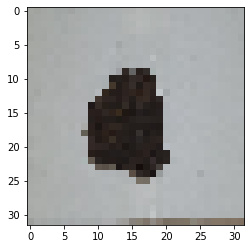

In [37]:
plt.imshow(X[0])

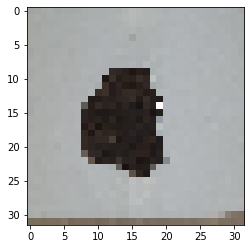

In [38]:
plt.imshow(temp[0])

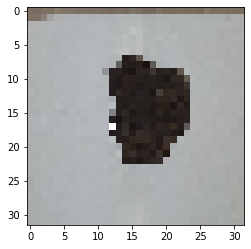

In [39]:
plt.imshow(X_[0])

In [40]:
tmp = cv2.rotate(temp[0], cv2.ROTATE_180)

In [53]:
pd.Series(np.reshape((tmp==X_[0]),-1)).value_counts()

True     1655
False    1417
dtype: int64

In [4]:
encoder = OneHotEncoder(sparse=False)
y = y.reshape(-1, 1)
encoder.fit(y)
y = encoder.transform(y)
y_ = encoder.transform(y.reshape(-1, 1))

In [5]:
X = np.append(X, X_, axis=0)
y = np.append(y, y, axis=0)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, shuffle=True)

*이미지는 메모리 한계상 32 * 32가 적당한 사이즈이며 이는 CIFAR-10의 사이즈와 동일하다
*하지만 CIFAT10은 이미지마다 확실한 차이가 눈에 보이지만 암석은 이미지가 비슷하믈

# Parameter for tuning
- Learning rate: 모델이 끝부분에 가면 accuracy, loss가 흔들림 lr을 낮추고 patience를 조금 올릴 것
- batch_size: resnet은 128만 train, 5만 val 셋에서 batch_size 256을 사용하였다.  CIFAR-10에서는 50000, 10000개 에서 batch_size 128을 사용하였다.
- Augmentation: CV2가 이미지를 주기적으로 회전해서 가져오는데 이는 모델에 큰 영향을 줄 수 있음 회전에 관한 augmentation 정도는 진행하면 좋을듯
*현재 accuracy가 97%이므로 위의 두개 항목만 튜닝하면 충분한 성능을 보여줄듯함

## 기본 모델 형태

In [7]:
es = keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=5, mode="max")

In [8]:
Input = keras.layers.Input(shape=X[0].shape)

x = keras.layers.Conv2D(16, kernel_size=3, activation="relu",kernel_initializer="he_normal", padding="same")(Input)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.MaxPool2D(2)(x)

x = keras.layers.Dropout(0.2)(x)

shortcut =x
x = keras.layers.Conv2D(32, kernel_size=3, activation="relu",kernel_initializer="he_normal", padding="same")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Conv2D(32, kernel_size=3, activation="relu",kernel_initializer="he_normal", padding="same")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Conv2D(32, kernel_size=3, activation="relu",kernel_initializer="he_normal", padding="same")(x)
shortcut = keras.layers.Conv2D(32, kernel_size=5, activation="relu",kernel_initializer="he_normal", padding="same")(shortcut)
x = keras.layers.Add()([x, shortcut])
x   = keras.layers.BatchNormalization()(x)
x = keras.layers.MaxPool2D(2)(x)


x = keras.layers.Dropout(0.2)(x)


shortcut =x
x = keras.layers.Conv2D(64, kernel_size=3, activation="relu",kernel_initializer="he_normal", padding="same")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Conv2D(64, kernel_size=3, activation="relu",kernel_initializer="he_normal", padding="same")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Conv2D(64, kernel_size=3, activation="relu",kernel_initializer="he_normal", padding="same")(x)
shortcut = keras.layers.Conv2D(64, kernel_size=3, activation="relu",kernel_initializer="he_normal", padding="same")(shortcut)
x = keras.layers.Add()([x, shortcut])
x = keras.layers.BatchNormalization()(x)
x = keras.layers.MaxPool2D(2)(x)

x = keras.layers.Dropout(0.2)(x)

shortcut =x
x = keras.layers.Conv2D(128, kernel_size=3, activation="relu",kernel_initializer="he_normal", padding="same")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Conv2D(128, kernel_size=3, activation="relu",kernel_initializer="he_normal", padding="same")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Conv2D(128, kernel_size=3, activation="relu",kernel_initializer="he_normal", padding="same")(x)
shortcut = keras.layers.Conv2D(128, kernel_size=3, activation="relu",kernel_initializer="he_normal", padding="same")(shortcut)
x = keras.layers.Add()([x, shortcut])
x = keras.layers.BatchNormalization()(x)
x = keras.layers.MaxPool2D(2)(x)

x = keras.layers.Dropout(0.2)(x)


x = keras.layers.GlobalAveragePooling2D()(x)
Output = keras.layers.Dense(4, activation="softmax")(x)

model = keras.models.Model(inputs = Input, outputs = Output)
model.compile(loss="categorical_crossentropy",
optimizer=keras.optimizers.Adam(learning_rate=0.0001), metrics=["accuracy"])

history = model.fit(X_train, y_train, validation_data=(X_test, y_test),callbacks=[es],epochs = 100)
print("Train: ", model.evaluate(X_train, y_train))
print("Valid: ", model.evaluate(X_test, y_test))

Epoch 1/100
342/342 [==============================] - 8s 16ms/step - loss: 1.3323 - accuracy: 0.5096 - val_loss: 5.8279 - val_accuracy: 0.1841
Epoch 2/100
342/342 [==============================] - 5s 14ms/step - loss: 0.9953 - accuracy: 0.6201 - val_loss: 2.2439 - val_accuracy: 0.3692
Epoch 3/100
342/342 [==============================] - 5s 14ms/step - loss: 0.8565 - accuracy: 0.6675 - val_loss: 1.5061 - val_accuracy: 0.5074
Epoch 4/100
342/342 [==============================] - 5s 14ms/step - loss: 0.7383 - accuracy: 0.6987 - val_loss: 1.6590 - val_accuracy: 0.4863
Epoch 5/100
342/342 [==============================] - 5s 14ms/step - loss: 0.6718 - accuracy: 0.7294 - val_loss: 1.3661 - val_accuracy: 0.5451
Epoch 6/100
342/342 [==============================] - 5s 14ms/step - loss: 0.6019 - accuracy: 0.7582 - val_loss: 1.3171 - val_accuracy: 0.5571
Epoch 7/100
342/342 [==============================] - 5s 14ms/step - loss: 0.5509 - accuracy: 0.7788 - val_loss: 1.0599 - val_accuracy:

In [14]:
history_list=[]

In [15]:
Input = keras.layers.Input(shape=X[0].shape)

x = keras.layers.Conv2D(16, kernel_size=3, activation="relu",kernel_initializer="he_normal", padding="same")(Input)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.MaxPool2D(2)(x)

x = keras.layers.Dropout(0.2)(x)

shortcut =x
x = keras.layers.Conv2D(32, kernel_size=3, activation="relu",kernel_initializer="he_normal", padding="same")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Conv2D(32, kernel_size=3, activation="relu",kernel_initializer="he_normal", padding="same")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Conv2D(32, kernel_size=3, activation="relu",kernel_initializer="he_normal", padding="same")(x)
shortcut = keras.layers.Conv2D(32, kernel_size=5, activation="relu",kernel_initializer="he_normal", padding="same")(shortcut)
x = keras.layers.Add()([x, shortcut])
x   = keras.layers.BatchNormalization()(x)
x = keras.layers.MaxPool2D(2)(x)


x = keras.layers.Dropout(0.2)(x)


shortcut =x
x = keras.layers.Conv2D(64, kernel_size=3, activation="relu",kernel_initializer="he_normal", padding="same")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Conv2D(64, kernel_size=3, activation="relu",kernel_initializer="he_normal", padding="same")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Conv2D(64, kernel_size=3, activation="relu",kernel_initializer="he_normal", padding="same")(x)
shortcut = keras.layers.Conv2D(64, kernel_size=3, activation="relu",kernel_initializer="he_normal", padding="same")(shortcut)
x = keras.layers.Add()([x, shortcut])
x = keras.layers.BatchNormalization()(x)
x = keras.layers.MaxPool2D(2)(x)

x = keras.layers.Dropout(0.2)(x)

shortcut =x
x = keras.layers.Conv2D(128, kernel_size=3, activation="relu",kernel_initializer="he_normal", padding="same")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Conv2D(128, kernel_size=3, activation="relu",kernel_initializer="he_normal", padding="same")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Conv2D(128, kernel_size=3, activation="relu",kernel_initializer="he_normal", padding="same")(x)
shortcut = keras.layers.Conv2D(128, kernel_size=3, activation="relu",kernel_initializer="he_normal", padding="same")(shortcut)
x = keras.layers.Add()([x, shortcut])
x = keras.layers.BatchNormalization()(x)
x = keras.layers.MaxPool2D(2)(x)

x = keras.layers.Dropout(0.2)(x)


x = keras.layers.GlobalAveragePooling2D()(x)
Output = keras.layers.Dense(4, activation="softmax")(x)

model = keras.models.Model(inputs = Input, outputs = Output)
model.compile(loss="categorical_crossentropy",
optimizer=keras.optimizers.Adam(learning_rate=0.0001), metrics=["accuracy"])

history_list.append(model.fit(X_train, y_train, validation_data=(X_test, y_test),callbacks=[es],epochs = 100))
print("Train: ", model.evaluate(X_train, y_train))
print("Valid: ", model.evaluate(X_test, y_test))

Epoch 1/100
342/342 [==============================] - 7s 16ms/step - loss: 1.0247 - accuracy: 0.5405 - val_loss: 5.6156 - val_accuracy: 0.1838
Epoch 2/100
342/342 [==============================] - 5s 15ms/step - loss: 0.8187 - accuracy: 0.6373 - val_loss: 2.5198 - val_accuracy: 0.3426
Epoch 3/100
342/342 [==============================] - 5s 15ms/step - loss: 0.7245 - accuracy: 0.6801 - val_loss: 1.4975 - val_accuracy: 0.4981
Epoch 4/100
342/342 [==============================] - 6s 17ms/step - loss: 0.6668 - accuracy: 0.7166 - val_loss: 1.3235 - val_accuracy: 0.5591
Epoch 5/100
342/342 [==============================] - 5s 15ms/step - loss: 0.6065 - accuracy: 0.7434 - val_loss: 1.4450 - val_accuracy: 0.5308
Epoch 6/100
342/342 [==============================] - 5s 15ms/step - loss: 0.5642 - accuracy: 0.7662 - val_loss: 1.1727 - val_accuracy: 0.6179
Epoch 7/100
342/342 [==============================] - 5s 14ms/step - loss: 0.5162 - accuracy: 0.7873 - val_loss: 0.9064 - val_accuracy:

In [16]:
Input = keras.layers.Input(shape=X[0].shape)

x = keras.layers.Conv2D(16, kernel_size=3, activation="relu",kernel_initializer="he_normal", padding="same")(Input)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.MaxPool2D(2)(x)

x = keras.layers.Dropout(0.2)(x)

shortcut =x
x = keras.layers.Conv2D(32, kernel_size=3, activation="relu",kernel_initializer="he_normal", padding="same")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Conv2D(32, kernel_size=3, activation="relu",kernel_initializer="he_normal", padding="same")(x)
# x = keras.layers.BatchNormalization()(x)
# x = keras.layers.Conv2D(32, kernel_size=3, activation="relu",kernel_initializer="he_normal", padding="same")(x)
shortcut = keras.layers.Conv2D(32, kernel_size=5, activation="relu",kernel_initializer="he_normal", padding="same")(shortcut)
x = keras.layers.Add()([x, shortcut])
x   = keras.layers.BatchNormalization()(x)
x = keras.layers.MaxPool2D(2)(x)


x = keras.layers.Dropout(0.2)(x)


shortcut =x
x = keras.layers.Conv2D(64, kernel_size=3, activation="relu",kernel_initializer="he_normal", padding="same")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Conv2D(64, kernel_size=3, activation="relu",kernel_initializer="he_normal", padding="same")(x)
# x = keras.layers.BatchNormalization()(x)
# x = keras.layers.Conv2D(64, kernel_size=3, activation="relu",kernel_initializer="he_normal", padding="same")(x)
shortcut = keras.layers.Conv2D(64, kernel_size=3, activation="relu",kernel_initializer="he_normal", padding="same")(shortcut)
x = keras.layers.Add()([x, shortcut])
x = keras.layers.BatchNormalization()(x)
x = keras.layers.MaxPool2D(2)(x)

x = keras.layers.Dropout(0.2)(x)

shortcut =x
x = keras.layers.Conv2D(128, kernel_size=3, activation="relu",kernel_initializer="he_normal", padding="same")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Conv2D(128, kernel_size=3, activation="relu",kernel_initializer="he_normal", padding="same")(x)
# x = keras.layers.BatchNormalization()(x)
# x = keras.layers.Conv2D(128, kernel_size=3, activation="relu",kernel_initializer="he_normal", padding="same")(x)
shortcut = keras.layers.Conv2D(128, kernel_size=3, activation="relu",kernel_initializer="he_normal", padding="same")(shortcut)
x = keras.layers.Add()([x, shortcut])
x = keras.layers.BatchNormalization()(x)
x = keras.layers.MaxPool2D(2)(x)

x = keras.layers.Dropout(0.2)(x)


x = keras.layers.GlobalAveragePooling2D()(x)
Output = keras.layers.Dense(4, activation="softmax")(x)

model = keras.models.Model(inputs = Input, outputs = Output)
model.compile(loss="categorical_crossentropy",
optimizer=keras.optimizers.Adam(learning_rate=0.0001), metrics=["accuracy"])

history_list.append(model.fit(X_train, y_train, validation_data=(X_test, y_test),callbacks=[es],epochs = 100))
print("Train: ", model.evaluate(X_train, y_train))
print("Valid: ", model.evaluate(X_test, y_test))

Epoch 1/100
342/342 [==============================] - 5s 13ms/step - loss: 0.9586 - accuracy: 0.6016 - val_loss: 8.9831 - val_accuracy: 0.1835
Epoch 2/100
342/342 [==============================] - 4s 12ms/step - loss: 0.6896 - accuracy: 0.7078 - val_loss: 1.6117 - val_accuracy: 0.4673
Epoch 3/100
342/342 [==============================] - 4s 12ms/step - loss: 0.5994 - accuracy: 0.7499 - val_loss: 0.9341 - val_accuracy: 0.6709
Epoch 4/100
342/342 [==============================] - 4s 12ms/step - loss: 0.5033 - accuracy: 0.7940 - val_loss: 0.6427 - val_accuracy: 0.7602
Epoch 5/100
342/342 [==============================] - 4s 12ms/step - loss: 0.4355 - accuracy: 0.8241 - val_loss: 0.5701 - val_accuracy: 0.7885
Epoch 6/100
342/342 [==============================] - 4s 12ms/step - loss: 0.4044 - accuracy: 0.8421 - val_loss: 0.5546 - val_accuracy: 0.7970
Epoch 7/100
342/342 [==============================] - 4s 12ms/step - loss: 0.3661 - accuracy: 0.8613 - val_loss: 0.5069 - val_accuracy:

In [17]:
Input = keras.layers.Input(shape=X[0].shape)

x = keras.layers.Conv2D(16, kernel_size=3, activation="relu",kernel_initializer="he_normal", padding="same")(Input)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.MaxPool2D(2)(x)


shortcut =x
x = keras.layers.Conv2D(32, kernel_size=3, activation="relu",kernel_initializer="he_normal", padding="same")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Conv2D(32, kernel_size=3, activation="relu",kernel_initializer="he_normal", padding="same")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Conv2D(32, kernel_size=3, activation="relu",kernel_initializer="he_normal", padding="same")(x)
shortcut = keras.layers.Conv2D(32, kernel_size=5, activation="relu",kernel_initializer="he_normal", padding="same")(shortcut)
x = keras.layers.Add()([x, shortcut])
x   = keras.layers.BatchNormalization()(x)
x = keras.layers.MaxPool2D(2)(x)




shortcut =x
x = keras.layers.Conv2D(64, kernel_size=3, activation="relu",kernel_initializer="he_normal", padding="same")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Conv2D(64, kernel_size=3, activation="relu",kernel_initializer="he_normal", padding="same")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Conv2D(64, kernel_size=3, activation="relu",kernel_initializer="he_normal", padding="same")(x)
shortcut = keras.layers.Conv2D(64, kernel_size=3, activation="relu",kernel_initializer="he_normal", padding="same")(shortcut)
x = keras.layers.Add()([x, shortcut])
x = keras.layers.BatchNormalization()(x)
x = keras.layers.MaxPool2D(2)(x)


shortcut =x
x = keras.layers.Conv2D(128, kernel_size=3, activation="relu",kernel_initializer="he_normal", padding="same")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Conv2D(128, kernel_size=3, activation="relu",kernel_initializer="he_normal", padding="same")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Conv2D(128, kernel_size=3, activation="relu",kernel_initializer="he_normal", padding="same")(x)
shortcut = keras.layers.Conv2D(128, kernel_size=3, activation="relu",kernel_initializer="he_normal", padding="same")(shortcut)
x = keras.layers.Add()([x, shortcut])
x = keras.layers.BatchNormalization()(x)
x = keras.layers.MaxPool2D(2)(x)



x = keras.layers.GlobalAveragePooling2D()(x)
Output = keras.layers.Dense(4, activation="softmax")(x)

model = keras.models.Model(inputs = Input, outputs = Output)
model.compile(loss="categorical_crossentropy",
optimizer=keras.optimizers.Adam(learning_rate=0.0001), metrics=["accuracy"])

history_list.append(model.fit(X_train, y_train, validation_data=(X_test, y_test),callbacks=[es],epochs = 100))
print("Train: ", model.evaluate(X_train, y_train))
print("Valid: ", model.evaluate(X_test, y_test))

Epoch 1/100
342/342 [==============================] - 6s 15ms/step - loss: 0.7395 - accuracy: 0.7071 - val_loss: 3.9910 - val_accuracy: 0.1920
Epoch 2/100
342/342 [==============================] - 5s 14ms/step - loss: 0.3305 - accuracy: 0.8906 - val_loss: 0.4240 - val_accuracy: 0.8486
Epoch 3/100
342/342 [==============================] - 5s 14ms/step - loss: 0.1836 - accuracy: 0.9473 - val_loss: 0.3460 - val_accuracy: 0.8766
Epoch 4/100
342/342 [==============================] - 5s 14ms/step - loss: 0.1022 - accuracy: 0.9759 - val_loss: 0.2919 - val_accuracy: 0.8975
Epoch 5/100
342/342 [==============================] - 5s 14ms/step - loss: 0.0530 - accuracy: 0.9920 - val_loss: 0.3179 - val_accuracy: 0.8964
Epoch 6/100
342/342 [==============================] - 5s 14ms/step - loss: 0.0357 - accuracy: 0.9951 - val_loss: 0.3246 - val_accuracy: 0.8964s - loss: 0.0358 - accuracy
Epoch 7/100
342/342 [==============================] - 5s 14ms/step - loss: 0.0228 - accuracy: 0.9972 - val_l

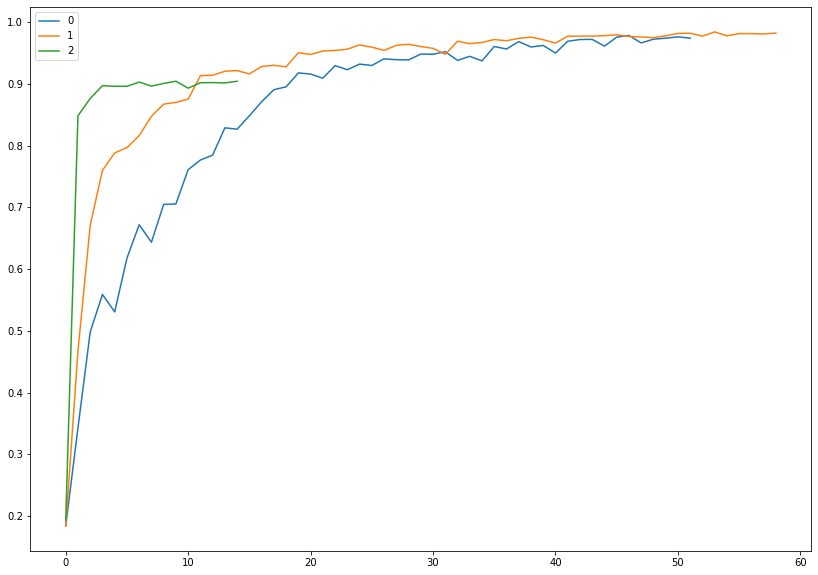

In [57]:
plt.figure(figsize=(14, 10))
for i in range(3):
    plt.plot(history_list[i].history["val_accuracy"], label=i)
    plt.legend()

In [54]:
history_list[1].history["val_accuracy"]

[0.1835164874792099,
 0.4673076868057251,
 0.6708791255950928,
 0.7601648569107056,
 0.7884615659713745,
 0.7969779968261719,
 0.8164834976196289,
 0.8478022217750549,
 0.8675824403762817,
 0.8703296780586243,
 0.8755494356155396,
 0.9137362837791443,
 0.9142857193946838,
 0.9208791255950928,
 0.9219779968261719,
 0.9164835214614868,
 0.9285714030265808,
 0.930494487285614,
 0.9280219674110413,
 0.9508242011070251,
 0.9480769038200378,
 0.9535714387893677,
 0.9546703100204468,
 0.95659339427948,
 0.9634615182876587,
 0.9598901271820068,
 0.9546703100204468,
 0.9629120826721191,
 0.9645604491233826,
 0.9609889984130859,
 0.9579670429229736,
 0.9483516216278076,
 0.9695054888725281,
 0.9656593203544617,
 0.9675824046134949,
 0.9722527265548706,
 0.9703296422958374,
 0.9741758108139038,
 0.976098895072937,
 0.9719780087471008,
 0.9664835333824158,
 0.9777472615242004,
 0.9777472615242004,
 0.9777472615242004,
 0.9785714149475098,
 0.9799450635910034,
 0.9771978259086609,
 0.97637361288070

## Learning_rate, batch_size tuning

In [109]:
history_dict={}

def lr_batch(lr=0.0001, batch=32):
    Input = keras.layers.Input(shape=X[0].shape)
    x = keras.layers.Conv2D(16, kernel_size=7, activation="relu",kernel_initializer="he_normal", padding="same")(Input)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPool2D(2)(x)

    x = keras.layers.Dropout(0.2)(x)

    shortcut =x
    x = keras.layers.Conv2D(32, kernel_size=3, activation="relu",kernel_initializer="he_normal", padding="same")(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv2D(32, kernel_size=3, activation="relu",kernel_initializer="he_normal", padding="same")(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv2D(32, kernel_size=3, activation="relu",kernel_initializer="he_normal", padding="same")(x)
    shortcut = keras.layers.Conv2D(32, kernel_size=5, activation="relu",kernel_initializer="he_normal", padding="same")(shortcut)
    x = keras.layers.Add()([x, shortcut])
    x   = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPool2D(2)(x)


    x = keras.layers.Dropout(0.2)(x)


    shortcut =x
    x = keras.layers.Conv2D(64, kernel_size=3, activation="relu",kernel_initializer="he_normal", padding="same")(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv2D(64, kernel_size=3, activation="relu",kernel_initializer="he_normal", padding="same")(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv2D(64, kernel_size=3, activation="relu",kernel_initializer="he_normal", padding="same")(x)
    shortcut = keras.layers.Conv2D(64, kernel_size=3, activation="relu",kernel_initializer="he_normal", padding="same")(shortcut)
    x = keras.layers.Add()([x, shortcut])
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPool2D(2)(x)

    x = keras.layers.Dropout(0.2)(x)

    shortcut =x
    x = keras.layers.Conv2D(128, kernel_size=3, activation="relu",kernel_initializer="he_normal", padding="same")(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv2D(128, kernel_size=3, activation="relu",kernel_initializer="he_normal", padding="same")(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv2D(128, kernel_size=3, activation="relu",kernel_initializer="he_normal", padding="same")(x)
    shortcut = keras.layers.Conv2D(128, kernel_size=3, activation="relu",kernel_initializer="he_normal", padding="same")(shortcut)
    x = keras.layers.Add()([x, shortcut])
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPool2D(2)(x)

    x = keras.layers.Dropout(0.2)(x)

    shortcut =x
    x = keras.layers.Conv2D(256, kernel_size=3, activation="relu",kernel_initializer="he_normal", padding="same")(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv2D(256, kernel_size=3, activation="relu",kernel_initializer="he_normal", padding="same")(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv2D(256, kernel_size=3, activation="relu",kernel_initializer="he_normal", padding="same")(x)
    shortcut = keras.layers.Conv2D(256, kernel_size=3, activation="relu",kernel_initializer="he_normal", padding="same")(shortcut)
    x = keras.layers.Add()([x, shortcut])
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPool2D(2)(x)

    x = keras.layers.GlobalAveragePooling2D()(x)
    Output = keras.layers.Dense(4, activation="softmax")(x)

    model = keras.models.Model(inputs = Input, outputs = Output)
    model.compile(loss="categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=lr), metrics=["accuracy"])

    history_dict[("learning_rate: "+str(lr)+ " batch_size"+ str(batch))] = (model.fit(X_train, y_train, validation_data=(X_test, y_test),callbacks=[es],epochs = 1000, batch_size=batch))
    print("Train: ", model.evaluate(X_train, y_train))
    print("Valid: ", model.evaluate(X_test, y_test))

In [110]:
for i in [0.001, 0.0001, 0.00001]:
    for b in [16, 32, 64]:
        lr_batch(i, b)

Epoch 1/1000
342/342 [==============================] - 10s 21ms/step - loss: 1.0414 - accuracy: 0.5445 - val_loss: 7.8028 - val_accuracy: 0.1835
Epoch 2/1000
342/342 [==============================] - 7s 19ms/step - loss: 0.7184 - accuracy: 0.6910 - val_loss: 0.7484 - val_accuracy: 0.6841
Epoch 3/1000
342/342 [==============================] - 7s 19ms/step - loss: 0.6037 - accuracy: 0.7527 - val_loss: 1.1508 - val_accuracy: 0.6066
Epoch 4/1000
342/342 [==============================] - 7s 20ms/step - loss: 0.4691 - accuracy: 0.8126 - val_loss: 1.0290 - val_accuracy: 0.6324
Epoch 5/1000
342/342 [==============================] - 7s 19ms/step - loss: 0.4008 - accuracy: 0.8462 - val_loss: 2.5261 - val_accuracy: 0.4500
Epoch 6/1000
342/342 [==============================] - 8s 23ms/step - loss: 0.3478 - accuracy: 0.8712 - val_loss: 0.3492 - val_accuracy: 0.8791
Epoch 7/1000
342/342 [==============================] - 10s 29ms/step - loss: 0.3105 - accuracy: 0.8870 - val_loss: 0.9510 - val_

57/57 [==============================] - 0s 7ms/step - loss: 0.6529 - accuracy: 0.8654
Valid:  [0.6528667211532593, 0.8653846383094788]
Epoch 1/1000
342/342 [==============================] - 8s 20ms/step - loss: 1.2679 - accuracy: 0.4723 - val_loss: 4.7307 - val_accuracy: 0.1835
Epoch 2/1000
342/342 [==============================] - 6s 19ms/step - loss: 1.0362 - accuracy: 0.5341 - val_loss: 3.5776 - val_accuracy: 0.2346
Epoch 3/1000
342/342 [==============================] - 6s 19ms/step - loss: 0.9232 - accuracy: 0.5701 - val_loss: 1.4253 - val_accuracy: 0.4330
Epoch 4/1000
342/342 [==============================] - 6s 18ms/step - loss: 0.8779 - accuracy: 0.6027 - val_loss: 1.5072 - val_accuracy: 0.4511
Epoch 5/1000
342/342 [==============================] - 6s 18ms/step - loss: 0.8206 - accuracy: 0.6196 - val_loss: 1.1173 - val_accuracy: 0.5159
Epoch 6/1000
342/342 [==============================] - 6s 18ms/step - loss: 0.7820 - accuracy: 0.6407 - val_loss: 1.2256 - val_accuracy: 0

342/342 [==============================] - 6s 18ms/step - loss: 0.1025 - accuracy: 0.9617 - val_loss: 0.7355 - val_accuracy: 0.8434
Epoch 57/1000
342/342 [==============================] - 6s 18ms/step - loss: 0.0906 - accuracy: 0.9694 - val_loss: 0.2568 - val_accuracy: 0.9148
Epoch 58/1000
342/342 [==============================] - 6s 18ms/step - loss: 0.1041 - accuracy: 0.9599 - val_loss: 0.2723 - val_accuracy: 0.9286
Epoch 59/1000
342/342 [==============================] - 6s 18ms/step - loss: 0.0851 - accuracy: 0.9689 - val_loss: 0.4559 - val_accuracy: 0.8544
Epoch 60/1000
342/342 [==============================] - 6s 18ms/step - loss: 0.0807 - accuracy: 0.9701 - val_loss: 0.2379 - val_accuracy: 0.9291
Epoch 61/1000
342/342 [==============================] - 6s 18ms/step - loss: 0.0808 - accuracy: 0.9727 - val_loss: 0.2438 - val_accuracy: 0.9264
Epoch 62/1000
342/342 [==============================] - 6s 18ms/step - loss: 0.0864 - accuracy: 0.9678 - val_loss: 0.2664 - val_accuracy:

86/86 [==============================] - 2s 22ms/step - loss: 0.4976 - accuracy: 0.7868 - val_loss: 0.8706 - val_accuracy: 0.6527
Epoch 29/1000
86/86 [==============================] - 2s 22ms/step - loss: 0.4921 - accuracy: 0.7925 - val_loss: 1.0431 - val_accuracy: 0.6016
Epoch 30/1000
86/86 [==============================] - 2s 22ms/step - loss: 0.4823 - accuracy: 0.7984 - val_loss: 0.9883 - val_accuracy: 0.6242
Epoch 31/1000
86/86 [==============================] - 2s 23ms/step - loss: 0.4746 - accuracy: 0.8013 - val_loss: 0.8759 - val_accuracy: 0.6736
Epoch 32/1000
86/86 [==============================] - 2s 23ms/step - loss: 0.4725 - accuracy: 0.8026 - val_loss: 1.1083 - val_accuracy: 0.6093
Epoch 33/1000
86/86 [==============================] - 2s 22ms/step - loss: 0.4496 - accuracy: 0.8086 - val_loss: 0.8145 - val_accuracy: 0.6923
Epoch 34/1000
86/86 [==============================] - 2s 22ms/step - loss: 0.4387 - accuracy: 0.8137 - val_loss: 0.6341 - val_accuracy: 0.7582 
Epoch

Epoch 85/1000
86/86 [==============================] - 2s 22ms/step - loss: 0.1064 - accuracy: 0.9592 - val_loss: 0.3427 - val_accuracy: 0.8923
Epoch 86/1000
86/86 [==============================] - 2s 22ms/step - loss: 0.0919 - accuracy: 0.9650 - val_loss: 0.4237 - val_accuracy: 0.8852
Epoch 87/1000
86/86 [==============================] - 2s 22ms/step - loss: 0.0922 - accuracy: 0.9663 - val_loss: 1.0180 - val_accuracy: 0.7456
Epoch 88/1000
86/86 [==============================] - 2s 22ms/step - loss: 0.0896 - accuracy: 0.9668 - val_loss: 0.3554 - val_accuracy: 0.8907
Epoch 89/1000
86/86 [==============================] - 2s 22ms/step - loss: 0.0793 - accuracy: 0.9703 - val_loss: 0.3871 - val_accuracy: 0.8923
Epoch 90/1000
86/86 [==============================] - 2s 24ms/step - loss: 0.0832 - accuracy: 0.9685 - val_loss: 0.3403 - val_accuracy: 0.9000
Epoch 91/1000
86/86 [==============================] - 2s 23ms/step - loss: 0.0760 - accuracy: 0.9701 - val_loss: 0.4280 - val_accuracy:

Epoch 78/1000
342/342 [==============================] - 6s 18ms/step - loss: 0.5749 - accuracy: 0.7502 - val_loss: 1.0644 - val_accuracy: 0.5896
Epoch 79/1000
342/342 [==============================] - 6s 18ms/step - loss: 0.5656 - accuracy: 0.7634 - val_loss: 1.0945 - val_accuracy: 0.5868
Epoch 80/1000
342/342 [==============================] - 6s 18ms/step - loss: 0.5755 - accuracy: 0.7604 - val_loss: 1.1301 - val_accuracy: 0.5852
Epoch 81/1000
342/342 [==============================] - 6s 18ms/step - loss: 0.5588 - accuracy: 0.7698 - val_loss: 1.0457 - val_accuracy: 0.5852
Epoch 82/1000
342/342 [==============================] - 6s 18ms/step - loss: 0.5520 - accuracy: 0.7661 - val_loss: 1.0576 - val_accuracy: 0.5940
Epoch 83/1000
342/342 [==============================] - 6s 18ms/step - loss: 0.5573 - accuracy: 0.7685 - val_loss: 0.9989 - val_accuracy: 0.6099
Epoch 84/1000
342/342 [==============================] - 6s 18ms/step - loss: 0.5503 - accuracy: 0.7665 - val_loss: 0.9983 -

342/342 [==============================] - 6s 18ms/step - loss: 0.2827 - accuracy: 0.8925 - val_loss: 0.4599 - val_accuracy: 0.8264
Epoch 189/1000
342/342 [==============================] - 6s 18ms/step - loss: 0.2933 - accuracy: 0.8857 - val_loss: 0.4389 - val_accuracy: 0.8330
Epoch 190/1000
342/342 [==============================] - 6s 17ms/step - loss: 0.2871 - accuracy: 0.8916 - val_loss: 0.4356 - val_accuracy: 0.8275
Epoch 191/1000
342/342 [==============================] - 6s 18ms/step - loss: 0.2889 - accuracy: 0.8888 - val_loss: 0.4227 - val_accuracy: 0.8407
Epoch 192/1000
342/342 [==============================] - 6s 17ms/step - loss: 0.2757 - accuracy: 0.8921 - val_loss: 0.3663 - val_accuracy: 0.8632
Epoch 193/1000
342/342 [==============================] - 6s 17ms/step - loss: 0.2807 - accuracy: 0.8877 - val_loss: 0.4374 - val_accuracy: 0.8363
Epoch 194/1000
342/342 [==============================] - 6s 17ms/step - loss: 0.2747 - accuracy: 0.8938 - val_loss: 0.4175 - val_acc

171/171 [==============================] - 3s 20ms/step - loss: 0.5889 - accuracy: 0.7386 - val_loss: 1.3910 - val_accuracy: 0.5132
Epoch 92/1000
171/171 [==============================] - 3s 20ms/step - loss: 0.5837 - accuracy: 0.7425 - val_loss: 1.4746 - val_accuracy: 0.5033
Epoch 93/1000
171/171 [==============================] - 3s 20ms/step - loss: 0.5803 - accuracy: 0.7495 - val_loss: 1.3723 - val_accuracy: 0.5330
Epoch 94/1000
171/171 [==============================] - 3s 20ms/step - loss: 0.5825 - accuracy: 0.7478 - val_loss: 1.4124 - val_accuracy: 0.5236
Epoch 95/1000
171/171 [==============================] - 3s 20ms/step - loss: 0.5792 - accuracy: 0.7564 - val_loss: 1.3424 - val_accuracy: 0.5319
Epoch 96/1000
171/171 [==============================] - 3s 19ms/step - loss: 0.5737 - accuracy: 0.7513 - val_loss: 1.3177 - val_accuracy: 0.5363
Epoch 97/1000
171/171 [==============================] - 4s 21ms/step - loss: 0.5730 - accuracy: 0.7531 - val_loss: 1.3904 - val_accuracy:

Epoch 147/1000
171/171 [==============================] - 3s 19ms/step - loss: 0.4446 - accuracy: 0.8147 - val_loss: 0.9703 - val_accuracy: 0.6610
Epoch 148/1000
171/171 [==============================] - 3s 19ms/step - loss: 0.4416 - accuracy: 0.8196 - val_loss: 0.9571 - val_accuracy: 0.6659
Epoch 149/1000
171/171 [==============================] - 3s 19ms/step - loss: 0.4289 - accuracy: 0.8240 - val_loss: 0.9472 - val_accuracy: 0.6725
Epoch 150/1000
171/171 [==============================] - 3s 19ms/step - loss: 0.4264 - accuracy: 0.8245 - val_loss: 1.0077 - val_accuracy: 0.6571
Epoch 151/1000
171/171 [==============================] - 3s 20ms/step - loss: 0.4344 - accuracy: 0.8216 - val_loss: 0.9977 - val_accuracy: 0.65884323 - accuracy: 
Epoch 152/1000
171/171 [==============================] - 3s 20ms/step - loss: 0.4404 - accuracy: 0.8201 - val_loss: 0.9343 - val_accuracy: 0.6747
Epoch 153/1000
171/171 [==============================] - 3s 19ms/step - loss: 0.4326 - accuracy: 0.8

86/86 [==============================] - 2s 23ms/step - loss: 0.9035 - accuracy: 0.5929 - val_loss: 2.6635 - val_accuracy: 0.2714
Epoch 51/1000
86/86 [==============================] - 2s 23ms/step - loss: 0.8949 - accuracy: 0.5923 - val_loss: 2.6668 - val_accuracy: 0.2698
Epoch 52/1000
86/86 [==============================] - 2s 23ms/step - loss: 0.8952 - accuracy: 0.5901 - val_loss: 2.4980 - val_accuracy: 0.2857
Epoch 53/1000
86/86 [==============================] - 2s 23ms/step - loss: 0.8957 - accuracy: 0.5863 - val_loss: 2.5700 - val_accuracy: 0.2791
Epoch 54/1000
86/86 [==============================] - 2s 23ms/step - loss: 0.8975 - accuracy: 0.5837 - val_loss: 2.5131 - val_accuracy: 0.2874
Epoch 55/1000
86/86 [==============================] - 2s 23ms/step - loss: 0.8797 - accuracy: 0.5941 - val_loss: 2.5210 - val_accuracy: 0.2863
Epoch 56/1000
86/86 [==============================] - 2s 23ms/step - loss: 0.8775 - accuracy: 0.5969 - val_loss: 2.4896 - val_accuracy: 0.2896
Epoch 

Epoch 107/1000
86/86 [==============================] - 2s 23ms/step - loss: 0.6831 - accuracy: 0.6899 - val_loss: 1.8835 - val_accuracy: 0.4297
Epoch 108/1000
86/86 [==============================] - 2s 23ms/step - loss: 0.6835 - accuracy: 0.6995 - val_loss: 1.7831 - val_accuracy: 0.4456
Epoch 109/1000
86/86 [==============================] - 2s 23ms/step - loss: 0.6750 - accuracy: 0.6962 - val_loss: 1.8601 - val_accuracy: 0.4363
Epoch 110/1000
86/86 [==============================] - 2s 24ms/step - loss: 0.6745 - accuracy: 0.6951 - val_loss: 1.8473 - val_accuracy: 0.4396
Epoch 111/1000
86/86 [==============================] - 2s 23ms/step - loss: 0.6784 - accuracy: 0.7057 - val_loss: 1.9547 - val_accuracy: 0.4286
Epoch 112/1000
86/86 [==============================] - 2s 23ms/step - loss: 0.6751 - accuracy: 0.7005 - val_loss: 1.8744 - val_accuracy: 0.4390
Epoch 113/1000
86/86 [==============================] - 2s 22ms/step - loss: 0.6781 - accuracy: 0.6954 - val_loss: 1.8549 - val_ac

86/86 [==============================] - 2s 22ms/step - loss: 0.4654 - accuracy: 0.8000 - val_loss: 1.1320 - val_accuracy: 0.6121
Epoch 220/1000
86/86 [==============================] - 2s 22ms/step - loss: 0.4549 - accuracy: 0.8104 - val_loss: 1.1446 - val_accuracy: 0.6077
Epoch 221/1000
86/86 [==============================] - 2s 22ms/step - loss: 0.4605 - accuracy: 0.8095 - val_loss: 1.1332 - val_accuracy: 0.6143
Epoch 222/1000
86/86 [==============================] - 2s 23ms/step - loss: 0.4485 - accuracy: 0.8119 - val_loss: 1.0684 - val_accuracy: 0.6236
Epoch 223/1000
86/86 [==============================] - 2s 23ms/step - loss: 0.4457 - accuracy: 0.8115 - val_loss: 1.1153 - val_accuracy: 0.6209
Epoch 224/1000
86/86 [==============================] - 2s 23ms/step - loss: 0.4479 - accuracy: 0.8123 - val_loss: 1.1281 - val_accuracy: 0.6231
Epoch 225/1000
86/86 [==============================] - 2s 24ms/step - loss: 0.4421 - accuracy: 0.8220 - val_loss: 1.1162 - val_accuracy: 0.6209


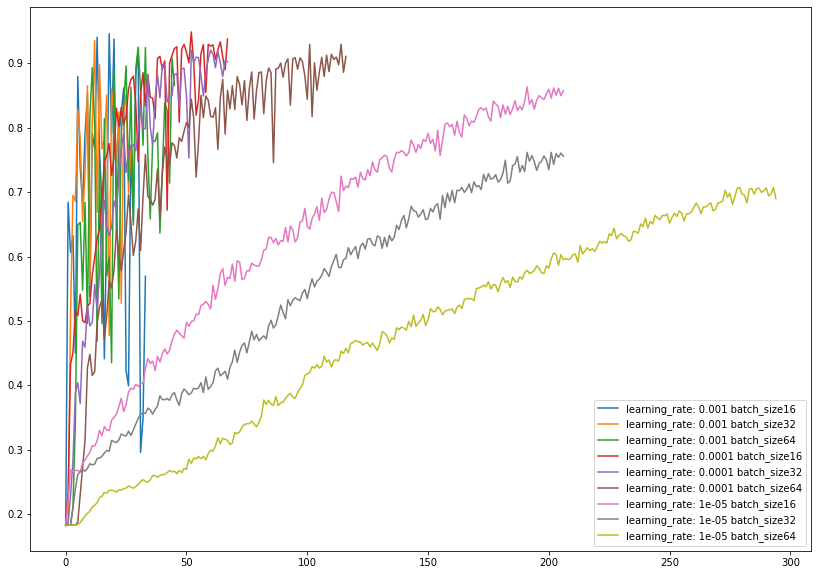

In [116]:
plt.figure(figsize=(14,10))
for i,k in history_dict.items():
    plt.plot(k.history["val_accuracy"], label=i)
    plt.legend(loc="lower right")
plt.show()

In [58]:
for i,k in history_dict.items():
    if i=="learning_rate: 0.0001 batch_size16":
        for j in range(len(k.history["val_accuracy"])):
            print("Train: ", k.history["val_accuracy"][j],"Valid: ", k.history["val_accuracy"][j])            

NameError: name 'history_dict' is not defined

In [130]:
for i,k in history_dict.items():
    if i=="learning_rate: 0.0001 batch_size32":
        for j in range(len(k.history["val_accuracy"])):
            print("Train: ", k.history["val_accuracy"][j],"Valid: ", k.history["val_accuracy"][j])            

Train:  0.1835164874792099 Valid:  0.1835164874792099
Train:  0.18626374006271362 Valid:  0.18626374006271362
Train:  0.22967033088207245 Valid:  0.22967033088207245
Train:  0.2824175953865051 Valid:  0.2824175953865051
Train:  0.3890109956264496 Valid:  0.3890109956264496
Train:  0.40439561009407043 Valid:  0.40439561009407043
Train:  0.3719780147075653 Valid:  0.3719780147075653
Train:  0.46868130564689636 Valid:  0.46868130564689636
Train:  0.4593406617641449 Valid:  0.4593406617641449
Train:  0.5230769515037537 Valid:  0.5230769515037537
Train:  0.4923076927661896 Valid:  0.4923076927661896
Train:  0.497802197933197 Valid:  0.497802197933197
Train:  0.5565934181213379 Valid:  0.5565934181213379
Train:  0.5170329809188843 Valid:  0.5170329809188843
Train:  0.5752747058868408 Valid:  0.5752747058868408
Train:  0.653296709060669 Valid:  0.653296709060669
Train:  0.6868131756782532 Valid:  0.6868131756782532
Train:  0.6461538672447205 Valid:  0.6461538672447205
Train:  0.63186812400817

In [131]:
for i,k in history_dict.items(): 
    if i=="learning_rate: 0.0001 batch_size64":
        for j in range(len(k.history["val_accuracy"])):
            print("Train: ", k.history["val_accuracy"][j],"Valid: ", k.history["val_accuracy"][j])            

Train:  0.1835164874792099 Valid:  0.1835164874792099
Train:  0.1835164874792099 Valid:  0.1835164874792099
Train:  0.1835164874792099 Valid:  0.1835164874792099
Train:  0.1835164874792099 Valid:  0.1835164874792099
Train:  0.1835164874792099 Valid:  0.1835164874792099
Train:  0.18791209161281586 Valid:  0.18791209161281586
Train:  0.23076923191547394 Valid:  0.23076923191547394
Train:  0.2725274860858917 Valid:  0.2725274860858917
Train:  0.3153846263885498 Valid:  0.3153846263885498
Train:  0.4274725317955017 Valid:  0.4274725317955017
Train:  0.44835165143013 Valid:  0.44835165143013
Train:  0.4153846204280853 Valid:  0.4153846204280853
Train:  0.4214285612106323 Valid:  0.4214285612106323
Train:  0.49670329689979553 Valid:  0.49670329689979553
Train:  0.5214285850524902 Valid:  0.5214285850524902
Train:  0.5324175953865051 Valid:  0.5324175953865051
Train:  0.47197800874710083 Valid:  0.47197800874710083
Train:  0.5082417726516724 Valid:  0.5082417726516724
Train:  0.56208789348602

In [98]:
for i, k in history_dict.items():
    print(k.history["val_accuracy"])

[0.8807692527770996]


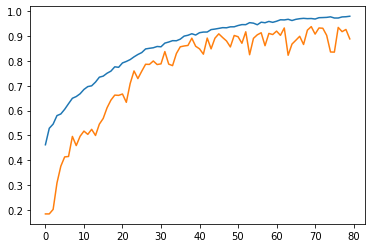

In [40]:
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])

In [41]:
Input = keras.layers.Input(shape=X[0].shape)

x = keras.layers.Conv2D(16, kernel_size=7, activation="relu",kernel_initializer="he_normal", padding="same")(Input)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.MaxPool2D(2)(x)

x = keras.layers.Dropout(0.2)(x)

shortcut =x
x = keras.layers.Conv2D(32, kernel_size=3, activation="relu",kernel_initializer="he_normal", padding="same")(x)
x = keras.layers.BatchNormalization()(x)
# x = keras.layers.Conv2D(32, kernel_size=3, activation="relu",kernel_initializer="he_normal", padding="same")(x)
# x = keras.layers.BatchNormalization()(x)
x = keras.layers.Conv2D(32, kernel_size=3, activation="relu",kernel_initializer="he_normal", padding="same")(x)
shortcut = keras.layers.Conv2D(32, kernel_size=5, activation="relu",kernel_initializer="he_normal", padding="same")(shortcut)
x = keras.layers.Add()([x, shortcut])
x   = keras.layers.BatchNormalization()(x)
x = keras.layers.MaxPool2D(2)(x)


x = keras.layers.Dropout(0.2)(x)


shortcut =x
x = keras.layers.Conv2D(64, kernel_size=3, activation="relu",kernel_initializer="he_normal", padding="same")(x)
x = keras.layers.BatchNormalization()(x)
# x = keras.layers.Conv2D(64, kernel_size=3, activation="relu",kernel_initializer="he_normal", padding="same")(x)
# x = keras.layers.BatchNormalization()(x)
x = keras.layers.Conv2D(64, kernel_size=3, activation="relu",kernel_initializer="he_normal", padding="same")(x)
shortcut = keras.layers.Conv2D(64, kernel_size=3, activation="relu",kernel_initializer="he_normal", padding="same")(shortcut)
x = keras.layers.Add()([x, shortcut])
x = keras.layers.BatchNormalization()(x)
x = keras.layers.MaxPool2D(2)(x)

x = keras.layers.Dropout(0.2)(x)

shortcut =x
x = keras.layers.Conv2D(128, kernel_size=3, activation="relu",kernel_initializer="he_normal", padding="same")(x)
x = keras.layers.BatchNormalization()(x)
# x = keras.layers.Conv2D(128, kernel_size=3, activation="relu",kernel_initializer="he_normal", padding="same")(x)
# x = keras.layers.BatchNormalization()(x)
x = keras.layers.Conv2D(128, kernel_size=3, activation="relu",kernel_initializer="he_normal", padding="same")(x)
shortcut = keras.layers.Conv2D(128, kernel_size=3, activation="relu",kernel_initializer="he_normal", padding="same")(shortcut)
x = keras.layers.Add()([x, shortcut])
x = keras.layers.BatchNormalization()(x)
x = keras.layers.MaxPool2D(2)(x)

x = keras.layers.Dropout(0.2)(x)

shortcut =x
x = keras.layers.Conv2D(256, kernel_size=3, activation="relu",kernel_initializer="he_normal", padding="same")(x)
x = keras.layers.BatchNormalization()(x)
# x = keras.layers.Conv2D(256, kernel_size=3, activation="relu",kernel_initializer="he_normal", padding="same")(x)
# x = keras.layers.BatchNormalization()(x)
x = keras.layers.Conv2D(256, kernel_size=3, activation="relu",kernel_initializer="he_normal", padding="same")(x)
shortcut = keras.layers.Conv2D(256, kernel_size=3, activation="relu",kernel_initializer="he_normal", padding="same")(shortcut)
x = keras.layers.Add()([x, shortcut])
x = keras.layers.BatchNormalization()(x)
x = keras.layers.MaxPool2D(2)(x)

x = keras.layers.Flatten()(x)
Output = keras.layers.Dense(4, activation="softmax")(x)

model = keras.models.Model(inputs = Input, outputs = Output)
model.compile(loss="categorical_crossentropy",
optimizer=keras.optimizers.Adam(learning_rate=0.0001), metrics=["accuracy"])

history = model.fit(X_train, y_train, validation_data=(X_test, y_test),callbacks=[es],epochs = 100)
print("Train: ", model.evaluate(X_train, y_train))
print("Valid: ", model.evaluate(X_test, y_test))

Epoch 1/100
171/171 [==============================] - 5s 20ms/step - loss: 1.2730 - accuracy: 0.4736 - val_loss: 5.2102 - val_accuracy: 0.1835
Epoch 2/100
171/171 [==============================] - 3s 18ms/step - loss: 1.0194 - accuracy: 0.5599 - val_loss: 5.8012 - val_accuracy: 0.1835
Epoch 3/100
171/171 [==============================] - 3s 18ms/step - loss: 0.9213 - accuracy: 0.5960 - val_loss: 4.1949 - val_accuracy: 0.2016
Epoch 4/100
171/171 [==============================] - 3s 17ms/step - loss: 0.8434 - accuracy: 0.6267 - val_loss: 2.0330 - val_accuracy: 0.3643
Epoch 5/100
171/171 [==============================] - 3s 18ms/step - loss: 0.8050 - accuracy: 0.6467 - val_loss: 1.8005 - val_accuracy: 0.3918
Epoch 6/100
171/171 [==============================] - 3s 18ms/step - loss: 0.7587 - accuracy: 0.6603 - val_loss: 1.6041 - val_accuracy: 0.4456
Epoch 7/100
171/171 [==============================] - 3s 19ms/step - loss: 0.7519 - accuracy: 0.6628 - val_loss: 1.5140 - val_accuracy: